In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.structural import UnobservedComponents
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import time

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True  # ensures deterministic algorithms
    torch.backends.cudnn.benchmark = False     # can slow down, but more reproducible

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class WeatherRNN(nn.Module):
  def __init__(self, input_size:int, hidden_size:int, output_size:int, num_layers:int=1, rnn_type:str='RNN', dropout:float=0.0):
    super().__init__()

    # potential RNN classes
    rnn_options = {"RNN": nn.RNN,
                   "LSTM": nn.LSTM,
                   "GRU": nn.GRU}

    if rnn_type not in rnn_options:
      raise ValueError(f'rnn_type must be one of {list(rnn_options.keys())}')

    # force dropout to be 0 if num_layers == 1
    dropout = dropout if num_layers > 1 else 0.0

    self.rnn_type = rnn_type

    # define the rnn
    self.rnn = rnn_options[rnn_type](input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

    # fully connected linear layers
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x, h0=None):
    batch_size = x.size(0)
    out, _ = self.rnn(x) if h0 is None else self.rnn(x, h0)
    out = self.fc(out[:,-1,:])
    return out, _
  

class TimeSeries(Dataset):
  def __init__(self, data, seq_len):
    self.data = torch.tensor(data, dtype=torch.float32)
    self.seq_len = seq_len

  def __len__(self):
    # subtract self.seq_len to account for data where previous sequence is unknown
    return len(self.data) - self.seq_len

  def __getitem__(self, start_idx):
    end_idx = start_idx + self.seq_len

    # generate the sequence of size seq_len and the target that follows directly after
    X_seq = self.data[start_idx:end_idx].unsqueeze(-1) # (seq_len x 1)
    y = self.data[end_idx].unsqueeze(-1) # (1,)

    return X_seq, y

In [4]:
def read_data(stations):
    # create array to store each dataframe created
    df_dict = {}         # each value in df_dict will be an dictionary with values of pd.DataFrame objects
                         # the key of each dataframe determines the type of dataset as shown below

    dataset_types = {
        0: "train",      # first element
        1: "validation", # second element
        2: "test"        # third element
    }

    # recover necessary data from each csv file
    for station in stations:

        for j in dataset_types.keys():
            df = pd.read_csv(f'../Project1/{dataset_types[j]}_data/{station}_weather_{dataset_types[j]}.csv')

            df["DATE"] = pd.to_datetime(df["DATE"])
        
            df.set_index("DATE", inplace=True)
        
            df = pd.DataFrame(df["TMAX"])

            # add dataframe to array
            df_dict[station] = [df] if station not in df_dict.keys() else df_dict[station] + [df]

    return df_dict

In [5]:
def normalize(df, col, transformation):

    # normalize data and append to array
    norm = transformation(df[col].values.reshape(-1,1))
    
    return norm

def to_dataset(data_norm, seq_len):
    dataset = TimeSeries(data_norm.values, seq_len=seq_len)
    return dataset

def to_loader(dataset, batch_size=32, shuffle=False, drop_last=True):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    return dataloader

In [6]:
def train_RNN(model, train_dataloader, validation_dataloader, num_epochs=50, 
              criterion=nn.MSELoss(), optimizer=optim.Adam, eta=1.e-3, device=device, show=True):
    
    model = model.to(device)

    training_loss = np.empty(num_epochs) * np.nan
    validation_loss = np.empty(num_epochs) * np.nan

    optimizer = optimizer(model.parameters(), lr=eta)

    #print("Training ...")

    #start_time = time.time()

    for epoch in range(num_epochs):
        # training and validation loss for each epoch
        train_epoch_loss = 0
        validation_epoch_loss = 0

        # reset hidden state after each epoch
        hidden = None

        model.train()
        for x_batch, y_batch in train_dataloader:
            if hidden is not None:
                if model.rnn_type == "LSTM":
                    hidden = (hidden[0].detach(), hidden[1].detach())
                else:
                    hidden = hidden.detach()

            out, hidden = model(x_batch, hidden)
            loss = criterion(out, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_epoch_loss += loss.item()
        
        # average loss over each batch
        train_epoch_loss /= len(train_dataloader)

        # save losses for plotting later
        training_loss[epoch] = train_epoch_loss

        
        model.eval()
        # reset hidden state
        hidden = None
        with torch.no_grad():
            for x_batch, y_batch in validation_dataloader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                if hidden is not None:
                    if model.rnn_type == "LSTM":
                        hiden = (hidden[0].detach(), hidden[1].detach())
                    else:
                        hidden = hidden.detach()

                out, hidden = model(x_batch, hidden)
                loss = criterion(out, y_batch)
                validation_epoch_loss += loss.item()
            
            validation_epoch_loss /= len(validation_dataloader)
        
        validation_loss[epoch] = validation_epoch_loss

        if show and epoch % 10 == 9:
            print(f'Epoch {epoch+1}: \n\tTraining Loss = {train_epoch_loss}\n\tValidation Loss = {validation_epoch_loss}')

    #end_time = time.time()

    #print("Done!")
    #print(f'Total time (seconds): {end_time-start_time}')

    return training_loss, validation_loss

In [7]:
def delete_data(df: pd.DataFrame | pd.Series, col: str, p: float, min_idx=None, max_idx=None):
    min_idx = 1 if min_idx is None else min_idx
    max_idx = len(df) - 1 if max_idx is None else max_idx

    nrows= int(p*(max_idx-min_idx)) # number of rows to remove

    col_index = df.columns.get_loc(col)    # column index as integer (for iloc)

    # ensure that indices are no smaller than min_idx and no larger than max_idx
    row_indices = np.random.choice(max_idx-(min_idx-1), size=nrows, replace=False) + min_idx

    df_na = df.copy()
    

    df_na.iloc[row_indices, col_index] = np.nan
    
    return df_na, row_indices

In [8]:
def kalman_smoother(df_na, indices, col="NORM", level='local linear trend', seasonal=None):
    model = UnobservedComponents(df_na[col], level=level, seasonal=seasonal)
    res = model.fit()
    smoothed = res.smoothed_state[0]

    df_na[f'{col}_KS'] = df_na[col]

    df_na.iloc[indices, -1] = smoothed[indices]

    return df_na

def unconditional_mean(df_na, indices, col="NORM"):
    df_na[f'[{col}]_UM"'] = df_na[col]

    df_na.iloc[indices, -1] = df_na[col].mean(skipna=True)

    return df_na

def impute_prev(df_na, indices, col="NORM"):
    df_na[f'{col}_IMPUTE_PREV'] = df_na[col]

    df_na.iloc[indices, -1] = df_na.iloc[indices-1, -1]

    return df_na

def linear_interpolate(df_na, indices, col="NORM"):
    # indices is a dummy variable so that all imputation functions take the same arguments
    df_na[f'{col}_LI'] = df_na[col].interpolate()
    
    return df_na

def impute_rolling(df_na, indices, col="NORM", window=3):
    # doesn't work if we get more than window consecutive nans
    df_na[f'{col}_IMPUTE_ROLLING_{window}'] = df_na[col]

    df_na.iloc[indices, -1] = df_na[col].rolling(window, min_periods=0).mean().iloc[indices]
    df_na[f'{col}_IMPUTE_ROLLING_{window}'] = df_na[f'{col}_IMPUTE_ROLLING_{window}'].ffill()
    

    return df_na

In [9]:
def simulate_data(ensemble_size, imputation_methods, percentages, seq_len, scaler=None, dataset_types=None):
    scaler = MinMaxScaler() if scaler is None else scaler
    dataset_types = dataset_types = {
        0: "train",      # first element
        1: "validation", # second element
     } if dataset_types is None else dataset_types

    all_datasets = {}

    for method in imputation_methods.keys():
        method_datasets = {}
        for p in percentages:
            for i in range(len(dataset_types)):
                dataset_type = dataset_types[i]

                data = []
                for n in range(ensemble_size):
                    df = pd.read_csv(f'../Project1/{dataset_type}_data/APA_weather_{dataset_type}.csv')
                    df.set_index("DATE", inplace=True)
                    df["NORM"] = normalize(df, "TMAX", scaler.fit_transform)

                    if dataset_type == "test":
                        dataset =  to_dataset(df["NORM"], seq_len=seq_len) # no need to remove and impute data for test set
                        
                    else:
                        df, indices = delete_data(df, "NORM", p=p)

                        df = imputation_methods[method](df, indices)

                        dataset = to_dataset(df.iloc[:, -1], seq_len=seq_len)
                    
                    data.append(dataset)

                if p not in method_datasets:
                    method_datasets[p] = {dataset_type: data}
                else:
                    method_datasets[p][dataset_type] = data  
                        
        all_datasets[method] = method_datasets
    return all_datasets

In [10]:
def train_member(train_dataset, val_dataset, hidden_size=16, model_type='RNN', num_epochs=30, seed=42, show=False):
    set_seed(seed)
    model = WeatherRNN(input_size=1,
                       hidden_size=hidden_size,
                       output_size=1,
                       num_layers=1,
                       rnn_type=model_type)
    
    train_loader = to_loader(train_dataset)
    val_loader = to_loader(val_dataset)
    
    train_loss, val_loss = train_RNN(model, train_loader, val_loader, num_epochs=num_epochs, show=show)
    return model, train_loss, val_loss

In [11]:
seq_len = 7
ensemble_size = 5
imputation_methods = {'KS': kalman_smoother,
                      'UM': unconditional_mean,
                      'LI': linear_interpolate}
percentages = [0.1, 0.25, 0.4]

scaler = MinMaxScaler()

warnings.filterwarnings('ignore')

datasets = simulate_data(ensemble_size, imputation_methods, percentages, seq_len, scaler=scaler)

In [12]:
num_epochs = 30
hidden_size = 16
model_type = 'RNN'

all_models = {}

loss = np.zeros([len(imputation_methods),
                          len(percentages),
                          ensemble_size,
                          num_epochs,
                          2])

num_models =  len(imputation_methods) * len(percentages) * ensemble_size

model_id = 1

print(f'Training {num_models} models\n')

start_time = time.time()

for m, method in enumerate(imputation_methods.keys()):
    for p_idx, p in enumerate(percentages):
        key = f'{p:.2f}_'[2:]+method
        all_models[key] = []
        
        train_datasets = datasets[method][p]['train']
        validation_datasets = datasets[method][p]['validation']
        #test_datasets =datasets[method][p]['test']

        """set_seed(42)
        ensemble = [WeatherRNN(input_size=1,
                                hidden_size=hidden_size,
                                output_size=1,
                                num_layers=1,
                                rnn_type=model_type) 
                    for _ in range(ensemble_size)]
        
        # Parallel training
        results = Parallel(n_jobs=-1)(
            delayed(train_member)(ensemble[n], loaders[method][p]['train'][n], loaders[method][p]['validation'][n], num_epochs=num_epochs)
            for n in range(ensemble_size)
        )"""

        ensemble = [train_member(train_datasets[n], validation_datasets[n], num_epochs=num_epochs) for n in range(ensemble_size)]


        for n, (model, train_loss, val_loss) in enumerate(ensemble):
            loss[m, p_idx, n, :, :] = np.stack((train_loss, val_loss), axis=1)
            all_models[key].append(model) # add model ensemble to dictionary

        print(f'{ensemble_size*model_id}/{num_models} models complete')
        model_id += 1

end_time = time.time()
print('Training done!')
print(f'Time Elapsed: {end_time-start_time:.3f}')

Training 45 models

5/45 models complete
10/45 models complete
15/45 models complete
20/45 models complete
25/45 models complete
30/45 models complete
35/45 models complete
40/45 models complete
45/45 models complete
Training done!
Time Elapsed: 305.588


In [13]:
for key, ensemble in all_models.items():
    for i, model in enumerate(ensemble):
        path = f"{key[-2:]}_model/model{i}.pt"
        torch.save(model.state_dict(), path)

In [14]:
def test_RNN(model, dataloader, seq_len, device=device):
    # returns normalized predictions
    # store predictions in an array
    predictions = np.empty([len(dataloader)+seq_len, 1])

    # first seq_len entries not available
    predictions[:seq_len] = np.nan

    model.eval()

    with torch.no_grad():
        idx = seq_len
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            
            # make prediction
            out, _ = model(x)

            # add prediction to array
            predictions[idx] = out.item()
            idx += 1

    return predictions



In [15]:
df_test = pd.read_csv('../Project1/test_data/APA_weather_test.csv')
df_test["DATE"] = pd.to_datetime(df_test["DATE"])
df_test.set_index("DATE", inplace=True)
df_test = pd.DataFrame(df_test["TMAX"])
df_test.rename(columns={"TMAX": "True"}, inplace=True)
df_test

,True
DATE,
2022-03-21,45.0
2022-03-22,40.0
2022-03-23,52.0
2022-03-24,64.0
2022-03-25,63.0
...,...
2025-03-30,52.0
2025-03-31,61.0
2025-04-01,51.0


In [16]:
test_norm = pd.Series(scaler.fit_transform(df_test).reshape(-1), index=df_test.index)
test_dataset = to_dataset(test_norm, seq_len=seq_len)
test_loader = to_loader(test_dataset,batch_size=1)

for method in imputation_methods.keys():
    for p in percentages:    
        key = f'{p:.2f}_'[2:]+method
        for n in range(ensemble_size):
            model = all_models[key][n]
            
            test_predictions = scaler.inverse_transform(test_RNN(model, test_loader, seq_len=seq_len))

            df_test[f'{key}_{n}'] = test_predictions
            
df_test = df_test.iloc[seq_len:]
df_test.head()

,True,10_KS_0,10_KS_1,10_KS_2,10_KS_3,10_KS_4,25_KS_0,25_KS_1,25_KS_2,25_KS_3,...,25_LI_0,25_LI_1,25_LI_2,25_LI_3,25_LI_4,40_LI_0,40_LI_1,40_LI_2,40_LI_3,40_LI_4
DATE,,,,,,,,,,,,,,,,,,,,,
2022-03-28,75.0,69.761596,69.364053,69.628573,69.646429,69.562694,69.727265,69.845447,69.955070,70.237124,...,69.864841,70.487364,70.024554,70.278551,69.970008,70.944440,71.552413,70.901377,71.256862,71.187310
2022-03-29,54.0,72.410571,72.238808,72.389864,72.487844,72.463884,72.577902,72.367728,72.475581,72.777552,...,72.749744,72.974528,72.659242,72.766183,72.861367,73.229278,73.205124,73.322097,72.962891,73.211720
2022-03-30,45.0,58.663590,58.551134,58.689708,58.073642,58.721523,59.850968,59.224275,60.060845,59.500274,...,55.084042,55.864648,55.436505,56.509537,55.537543,53.969115,53.882279,53.555746,54.120049,53.413354
2022-03-31,60.0,54.811770,54.928153,55.132175,54.902758,55.249385,54.960819,54.126797,54.752639,54.562850,...,52.682504,52.745046,52.637910,53.274251,53.385776,51.143532,50.298165,50.695527,50.557512,50.063800
2022-04-01,56.0,65.412107,65.237632,65.784225,65.873840,65.895380,63.623211,63.674986,64.002449,64.670636,...,65.704654,66.424020,65.893805,66.383426,66.137746,66.656500,66.604945,66.284892,66.588353,66.203261


In [17]:
# store all RMSE and biases in 3d numpy arrays to compute the mean and std

RMSE = np.zeros([len(imputation_methods),
                 len(percentages),
                 ensemble_size])

bias = np.zeros([len(imputation_methods),
                 len(percentages),
                 ensemble_size])

df_results =pd.DataFrame({'Method': [],
                          'p': [],
                          'RMSE': [],
                          'Bias': []})

num_methods = len(imputation_methods)
num_p = len(percentages)

for m, method in enumerate(imputation_methods.keys()):
    for p_idx, p in enumerate(percentages):
        for n in range(ensemble_size):
            col=f'{p:.2f}'[-2:]+f'_{method}_{n}'
            RMSE[m, p_idx, n] = root_mean_squared_error(df_test['True'], df_test[col])
            bias[m, p_idx, n] = (df_test['True']-df_test[col]).mean()

            df_idx = n + p_idx*ensemble_size + m*ensemble_size*num_p
            df_results.loc[df_idx] = [method, p, RMSE[m,p_idx,n], bias[m,p_idx,n]]

df_results

,Method,p,RMSE,Bias
0,KS,0.10,9.451117,-1.750054
1,KS,0.10,9.450848,-1.828797
2,KS,0.10,9.473142,-1.874991
3,KS,0.10,9.472436,-1.920847
4,KS,0.10,9.508270,-2.084526
5,KS,0.25,9.467565,-1.529484
6,KS,0.25,9.408840,-1.276318
7,KS,0.25,9.482722,-1.661579
8,KS,0.25,9.493665,-1.838780
9,KS,0.25,9.525205,-1.872818


In [18]:
RMSE_stats = np.zeros([len(imputation_methods),
                       len(percentages),
                       2])

bias_stats = np.zeros([len(imputation_methods),
                       len(percentages),
                       2])
RMSE_stats = np.stack([RMSE.mean(axis=2), RMSE.std(axis=2)], axis=-1)

bias_stats = np.stack([bias.mean(axis=2), bias.std(axis=2)], axis=-1)

In [19]:
df_stats = pd.DataFrame({"Method": [],
                         "p": [],
                         "RMSE_mean": [],
                         "RMSE_std": [],
                         "Bias_mean": [],
                         "Bias_std": []})



for m, method in enumerate(imputation_methods):
    for p_idx, p in enumerate(percentages):
        idx = p_idx + m*num_methods

        df_stats.loc[idx] = [method, p, RMSE_stats[m,p_idx,0], RMSE_stats[m,p_idx,1], bias_stats[m,p_idx,0], bias_stats[m,p_idx,1]]


df_stats.set_index(['Method', 'p'], inplace=True)
df_stats.T

Method           KS                            UM                        \
p              0.10      0.25      0.40      0.10       0.25       0.40   
RMSE_mean  9.471163  9.475600  9.668290  9.707942  10.337697  11.035346   
RMSE_std   0.020962  0.038364  0.050886  0.045328   0.146612   0.215155   
Bias_mean -1.891843 -1.635796 -1.913704 -1.768156  -1.994563  -2.272528   
Bias_std   0.111652  0.218437  0.154356  0.180841   0.684887   0.559210   

Method           LI                      
p              0.10      0.25      0.40  
RMSE_mean  9.476374  9.471575  9.601220  
RMSE_std   0.036267  0.023978  0.016490  
Bias_mean -1.950689 -1.597286 -1.131904  
Bias_std   0.155609  0.163215  0.077674

### We can visualize the RMSE and bias using box plots to show their means and spread. Note that the sample size is quite small, so this may not be truly representative of the population statistics. Nevertheless, I think it's worth looking at.

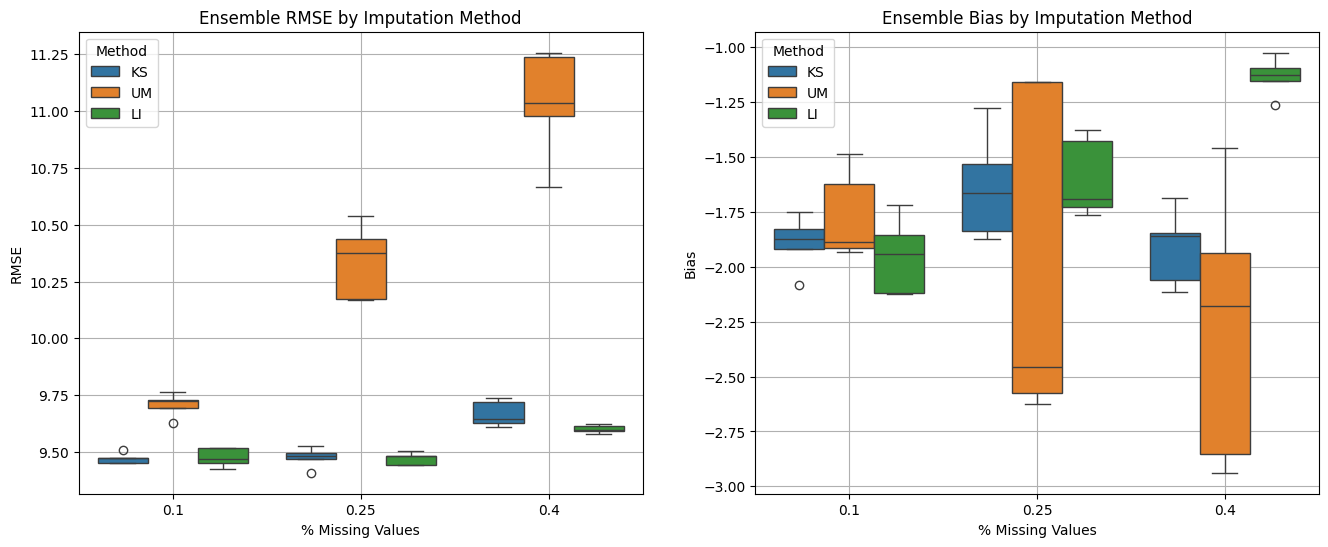

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

sns.boxplot(data=df_results, x='p', y='RMSE', hue='Method', ax=ax1)
ax1.set_title("Ensemble RMSE by Imputation Method")
ax1.set_xlabel("% Missing Values")
ax1.grid()

sns.boxplot(data=df_results, x='p', y='Bias', hue='Method', ax=ax2)
ax2.set_title("Ensemble Bias by Imputation Method")
ax2.set_xlabel("% Missing Values")
ax2.grid()

### The unconditional mean imputaion has a mean RMSE that seems to be different from the mean RMSE of the Kalman Smoothing and linear interpolation methods. It also tends to have a greater spread than the other two methods. All of the models tend to underestimate the temperature on average. Again, we see that the unconditional mean imputation method produces wildly different biases depending on the dataset. This seemingly large spread could be a result of the small sample size.

### Next we can plot the ensemble mean predictions of all 9 datasets.

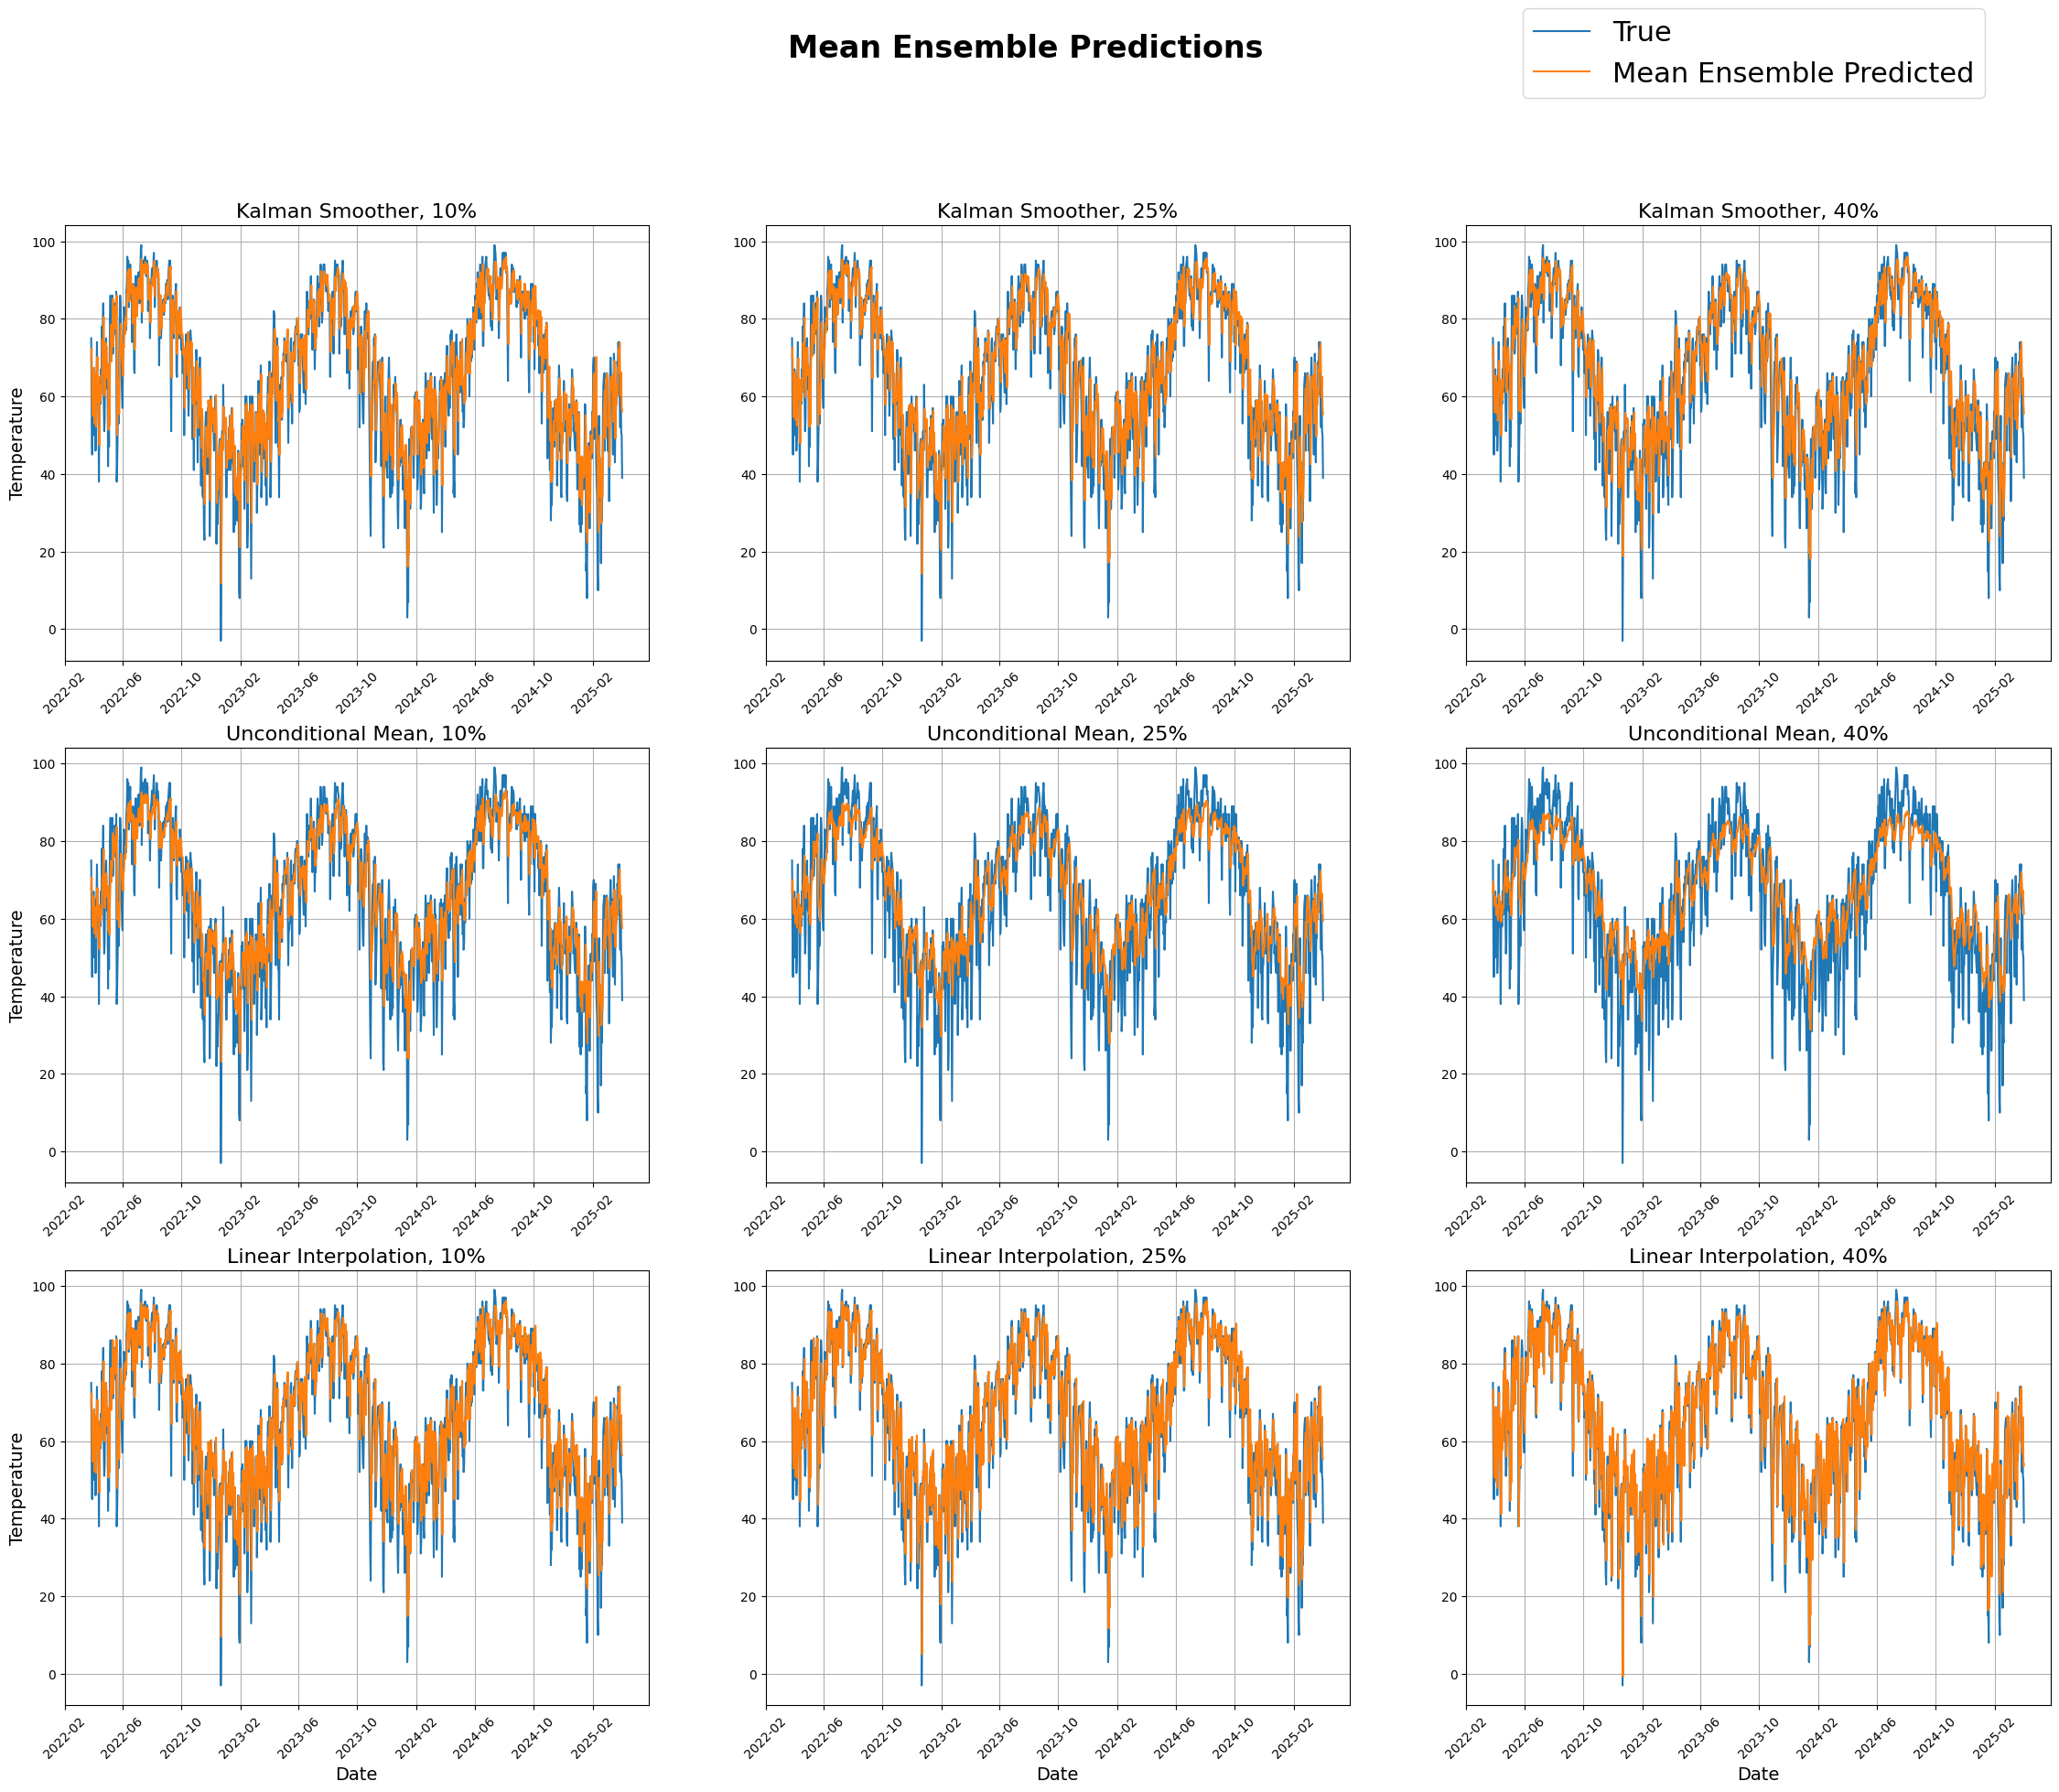

In [21]:
fig, ax = plt.subplots(nrows=len(imputation_methods), ncols=len(percentages), figsize=(28,21))

num_methods = len(imputation_methods)
num_p = len(percentages)

method_names  = {'KS': 'Kalman Smoother',
                 'UM': 'Unconditional Mean',
                 'LI': 'Linear Interpolation'}

for m, method in enumerate(imputation_methods):
    for p_idx, p in enumerate(percentages):
        col=f'{p:.2f}'[-2:]+f'_{method}_'
        ax[m, p_idx].plot(df_test['True'], label='True')
        ax[m, p_idx].plot(df_test[[col+f'{n}' for n in range(ensemble_size)]].mean(axis=1), label='Mean Ensemble Predicted')

        ax[m, p_idx].grid()
        ax[m, p_idx].set_title(f'{method_names[method]}, ' + f'{p:.2f}'[-2:]+'%', fontsize=16)

        locator = mdates.MonthLocator(interval=4)
        formatter = mdates.DateFormatter('%Y-%m')  

        ax[m, p_idx].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
        ax[m, p_idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax[m, p_idx].tick_params(axis='x', rotation=45)


        if m == (len(imputation_methods) - 1):
            ax[m, p_idx].set_xlabel('Date', fontsize=14)

        if p_idx == 0:
            ax[m, p_idx].set_ylabel('Temperature', fontsize=14)

        #break
    #break
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.88,1), fontsize=22)
fig.suptitle('Mean Ensemble Predictions', fontweight='bold', fontsize=24)
plt.show()